### An illustration of FBPINN training

In [2]:
import os
import sys
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Optional: Add project root to PYTHONPATH if needed
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from utils.data_utils import generate_subdomains, generate_collocation_points
from utils.window_function import my_precise_window_func
#from model.fbpinn_model import FBPINN
from train.trainer_fbpinn import train_fbpinn
#from physics.problems import CosineODE as pde_module

#problem = pde_module()  # 实例化，绑定self
#pde_residual_loss = problem.residual  
#u_exact = problem.exact
#ansatz = problem.ansatz
#domain = problem.domain

# Training hyperparameters
steps = 50000
lr = 1e-3
n_sub = 30
overlap = 0.3
n_points_per_subdomain = 100 # All together 1000

mlp_config = {
    "in_size": 1,
    "out_size": 1,
    "width_size": 16,
    "depth": 2,
    "activation": jax.nn.tanh,
}

'''left, right = pde_module.domain  # 此时 left=0, right=3
domain = (jnp.array([left]), jnp.array([right]))        # 变为 [[0, 3]]
print(domain)'''


'left, right = pde_module.domain  # 此时 left=0, right=3\ndomain = (jnp.array([left]), jnp.array([right]))        # 变为 [[0, 3]]\nprint(domain)'

### Generate subdomains and collocation points

In [3]:


'''subdomain_collocation_points, _ = generate_collocation_points(
domain=domain,
subdomains_list=subdomains_list,
n_points_per_subdomain=n_points_per_subdomain,
seed=0
)'''

def print_collocation_ranges(subdomain_points):
    for i, pts in enumerate(subdomain_points):
        pts = jnp.asarray(pts)

        if pts.ndim == 1:                    # ---- 1-D 情况
            lo = float(pts.min())
            hi = float(pts.max())
            ranges = f"d0: [{lo:.4f}, {hi:.4f}]"
        else:                                # ---- d ≥ 2
            mins = pts.min(axis=0)
            maxs = pts.max(axis=0)
            ranges = ", ".join(
                f"d{j}: [{float(mins[j]):.4f}, {float(maxs[j]):.4f}]"
                for j in range(pts.shape[1])
            )

        print(f"Subdomain {i}: {ranges}   (N={pts.shape[0]})")
#print_collocation_ranges(subdomain_collocation_points)

### Plot of window function

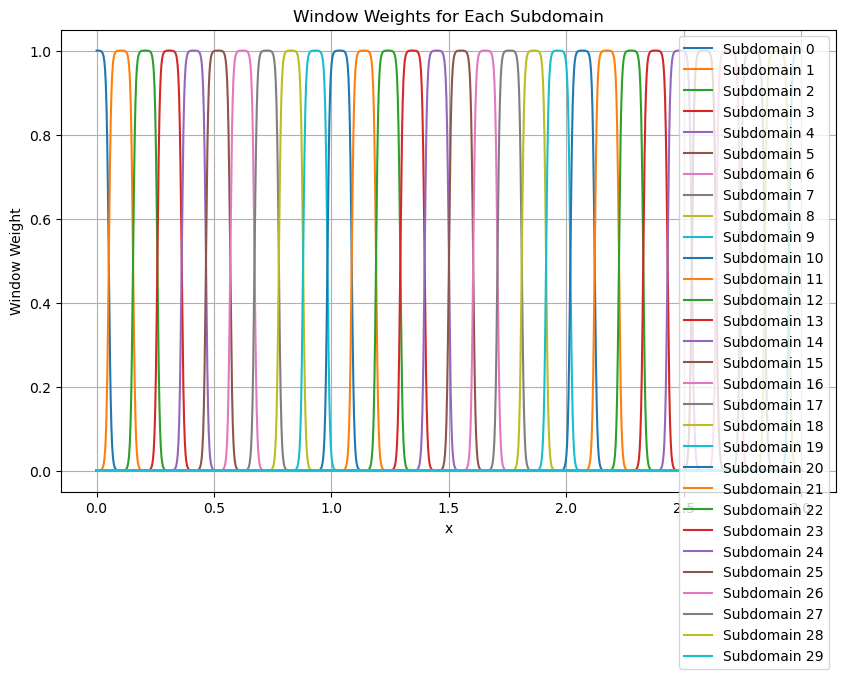

In [3]:
# illustration of window function
x_test =  jnp.linspace(0, 3, 1000).reshape(-1, 1) 
n_sub = 30

x_plot = jnp.linspace(left, right,1000).reshape(-1, 1)
xmins = jnp.stack([s[0] for s in subdomains_list])
xmaxs = jnp.stack([s[1] for s in subdomains_list])
wmins = jnp.full_like(xmins, overlap)
wmaxs = jnp.full_like(xmaxs, overlap)
w = my_precise_window_func(xmins, xmaxs, wmins, wmaxs, x_plot, tol=1e-3)
# illustration of window function
x_test =  jnp.linspace(0, 3, 1000).reshape(-1, 1)
# plot
plt.figure(figsize=(10, 6))
for i in range(w.shape[1]):
    plt.plot(x_test, w[:, i], label=f"Subdomain {i}")
plt.xlabel('x')
plt.ylabel('Window Weight')
plt.legend()
plt.title('Window Weights for Each Subdomain')
plt.grid(True)
plt.show()

Stacked 30 subdomains' points. Shape: (30, 100, 1)


/tmp/ipykernel_1034401/4018170640.py:420: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  fb_model = FBPINN(key, subdomains_list, ansatz, mlp_config, ftw_win, problem_omega=problem.omega)


FBPINN init with 30 subdomains.


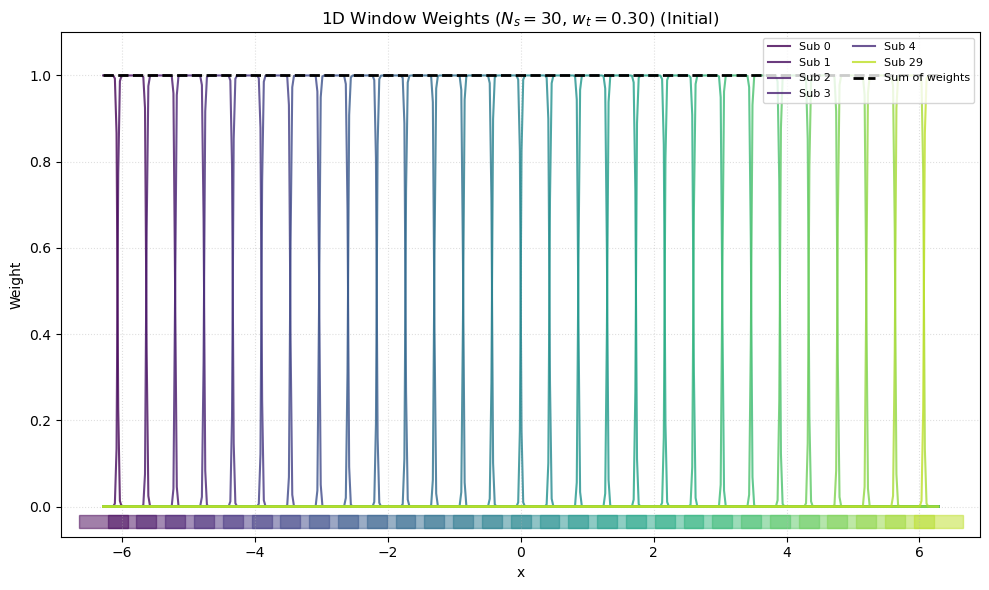


Starting training...
S      0, PDE Loss: 1.607e+01, L1 Err: 4.332e-02
S    100, PDE Loss: 1.238e+01, L1 Err: 3.989e-02
S    200, PDE Loss: 8.810e+00, L1 Err: 5.534e-02
S    300, PDE Loss: 4.612e+00, L1 Err: 6.048e-02
S    400, PDE Loss: 2.518e+00, L1 Err: 5.670e-02
S    500, PDE Loss: 1.414e+00, L1 Err: 5.164e-02
S    600, PDE Loss: 7.576e-01, L1 Err: 4.043e-02
S    700, PDE Loss: 2.317e-01, L1 Err: 3.101e-02
S    800, PDE Loss: 8.309e-02, L1 Err: 2.591e-02
S    900, PDE Loss: 4.342e-02, L1 Err: 2.219e-02
S   1000, PDE Loss: 2.428e-02, L1 Err: 1.890e-02
S   1100, PDE Loss: 1.587e-02, L1 Err: 1.627e-02
S   1200, PDE Loss: 1.169e-02, L1 Err: 1.414e-02
S   1300, PDE Loss: 9.061e-03, L1 Err: 1.238e-02
S   1400, PDE Loss: 7.228e-03, L1 Err: 1.087e-02
S   1500, PDE Loss: 5.894e-03, L1 Err: 9.544e-03
S   1600, PDE Loss: 4.894e-03, L1 Err: 8.358e-03
S   1700, PDE Loss: 4.125e-03, L1 Err: 7.285e-03
S   1800, PDE Loss: 3.520e-03, L1 Err: 6.308e-03
S   1900, PDE Loss: 3.036e-03, L1 Err: 5.417e-0

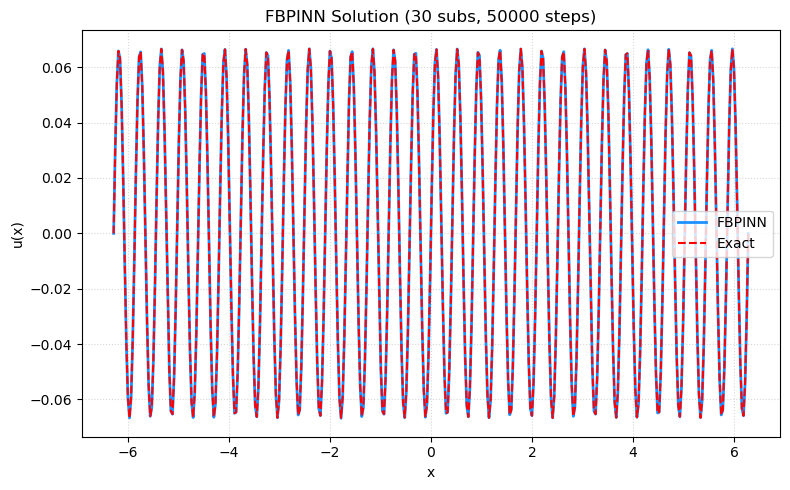

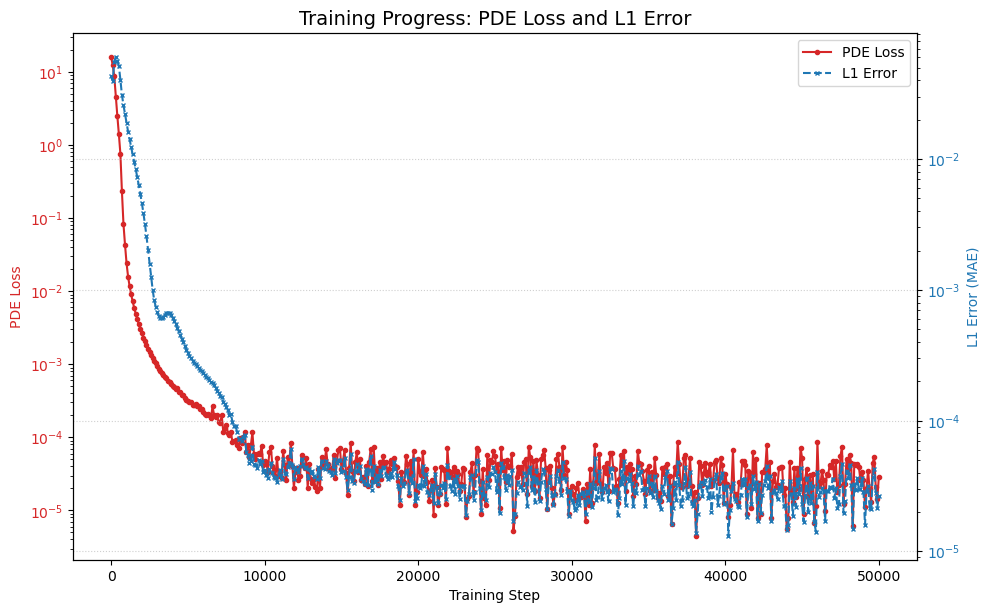

In [1]:
import sys
import numpy as np
# import traceback # traceback 在精简版中未使用，如果需要可以取消注释
from functools import partial
import jax
import jax.numpy as jnp
import optax
import equinox as eqx
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
jax.config.update("jax_enable_x64", True)

########################################################################
#                                     1. 辅助函数
########################################################################

def my_precise_window_func(
        xmins_all, xmaxs_all, wmins_all, wmaxs_all, x, tol=1e-8, epsilon=1e-9
    ):
    x = jnp.atleast_2d(x)
    N, d_spatial = x.shape
    n_sub = xmins_all.shape[0]

    if not (xmins_all.shape == (n_sub, d_spatial) and
            xmaxs_all.shape == (n_sub, d_spatial) and
            wmins_all.shape == (n_sub, d_spatial) and
            wmaxs_all.shape == (n_sub, d_spatial)):
        raise ValueError("Shape mismatch in window function input arrays.")

    t = jnp.log((1 - tol) / tol)
    mu_min = xmins_all + wmins_all / 2.0
    sd_min = wmins_all / (2.0 * t)
    mu_max = xmaxs_all - wmaxs_all / 2.0
    sd_max = wmaxs_all / (2.0 * t)

    x_expanded = x[:, None, :]
    left_sig_arg = (x_expanded - mu_min) / (sd_min + epsilon)
    right_sig_arg = (mu_max - x_expanded) / (sd_max + epsilon)
    left_sig = jax.nn.sigmoid(left_sig_arg)
    right_sig = jax.nn.sigmoid(right_sig_arg)
    prod_sigmoids_per_dim = left_sig * right_sig
    w_raw = jnp.prod(prod_sigmoids_per_dim, axis=-1)
    return w_raw

def generate_subdomains_center_at_boundary(
        domain_tuple, n_sub, fixed_physical_overlap_width, xdim=1
    ):
    min_val_arr, max_val_arr = domain_tuple
    domain_min_val_xdim = jnp.asarray(min_val_arr).reshape(xdim)
    domain_max_val_xdim = jnp.asarray(max_val_arr).reshape(xdim)

    domain_min_scalar = domain_min_val_xdim[0].item()
    domain_max_scalar = domain_max_val_xdim[0].item()
    domain_length = domain_max_scalar - domain_min_scalar

    if n_sub == 0: return []
    if n_sub == 1: return [(domain_min_val_xdim, domain_max_val_xdim)]

    if domain_length <= 1e-7 and xdim == 1:
        pt_arr = domain_min_val_xdim
        return [(pt_arr, pt_arr) for _ in range(n_sub)]

    center_step_scalar = domain_length / (n_sub - 1)
    subdomain_len_scalar = center_step_scalar + fixed_physical_overlap_width

    if subdomain_len_scalar <= 1e-7: # Fallback
        print(f"Warning: Calculated subdomain length ({subdomain_len_scalar:.4f}) is too small. Fallbacking.")
        subdomains = []
        subdomain_len_fb = domain_length / n_sub
        current_min_fb = domain_min_scalar
        for i in range(n_sub):
            s_min_fb = current_min_fb
            s_max_fb = current_min_fb + subdomain_len_fb
            if i == n_sub - 1: s_max_fb = domain_max_scalar
            
            s_min_fb_clipped = jnp.maximum(s_min_fb, domain_min_scalar)
            s_max_fb_clipped = jnp.minimum(s_max_fb, domain_max_scalar)

            if s_max_fb_clipped > s_min_fb_clipped + 1e-7:
                subdomains.append(
                    (jnp.full(xdim, s_min_fb_clipped), jnp.full(xdim, s_max_fb_clipped))
                )
            current_min_fb = s_max_fb
        if not subdomains and n_sub > 0: return [(domain_min_val_xdim, domain_max_val_xdim)]
        return subdomains

    subdomains = []
    for i in range(n_sub):
        center_i_scalar = domain_min_scalar + i * center_step_scalar
        if i == n_sub - 1: center_i_scalar = domain_max_scalar
        
        center_i_xdim = jnp.copy(domain_min_val_xdim) 
        center_i_xdim = center_i_xdim.at[0].set(center_i_scalar)

        s_min_i_xdim = center_i_xdim - subdomain_len_scalar / 2.0
        s_max_i_xdim = center_i_xdim + subdomain_len_scalar / 2.0
        subdomains.append((s_min_i_xdim, s_max_i_xdim))
    return subdomains

def generate_collocation_points(
        domain_tuple_original_problem, subdomains_list, n_points_per_subdomain, seed, xdim=1
    ):
    global_min_scalar = float(domain_tuple_original_problem[0])
    global_max_scalar = float(domain_tuple_original_problem[1])
    all_points_list = []

    for i, (s_min_arr_orig, s_max_arr_orig) in enumerate(subdomains_list):
        s_min_orig_scalar = s_min_arr_orig[0].item()
        s_max_orig_scalar = s_max_arr_orig[0].item()

        eff_s_min_scalar = jnp.maximum(s_min_orig_scalar, global_min_scalar)
        eff_s_max_scalar = jnp.minimum(s_max_orig_scalar, global_max_scalar)
        current_points_array = jnp.empty((0, xdim), dtype=jnp.float64)

        if n_points_per_subdomain == 0: pass
        elif eff_s_min_scalar < eff_s_max_scalar:
            if n_points_per_subdomain == 1:
                point_val_dim0 = (eff_s_min_scalar + eff_s_max_scalar) / 2.0
                current_points_array = jnp.array([[point_val_dim0]], dtype=jnp.float64) 
            else:
                points_dim0 = jnp.linspace(eff_s_min_scalar, eff_s_max_scalar, n_points_per_subdomain, dtype=jnp.float64)
                current_points_array = points_dim0.reshape(-1,1) 
        elif eff_s_min_scalar == eff_s_max_scalar and n_points_per_subdomain > 0:
            points_dim0 = jnp.full((n_points_per_subdomain,), eff_s_min_scalar, dtype=jnp.float64)
            current_points_array = points_dim0.reshape(-1,1) 
        
        all_points_list.append(current_points_array)
    return all_points_list, []

########################################################################
#                                     2. PDE 定义
########################################################################
class PDEProblem:
    domain = (None, None)
    def residual(self, model, x): raise NotImplementedError
    def exact(self, x): raise NotImplementedError
    def ansatz(self, x, nn_out): raise NotImplementedError

class CosineODE(PDEProblem):
    omega = 15.0
    domain = (-2 * jnp.pi, 2 * jnp.pi)

    @staticmethod
    def ansatz(x, nn_out):
        # Re-instating the tanh factor to enforce u(0)=0 boundary condition
        # nn_out is total_out from FBPINN, which includes the 1/omega unnormalisation
        x_squeezed = x[..., 0] if x.ndim > 1 and x.shape[-1] > 0 else x
        if x.ndim == 1 and x.shape[-1] > 0 : 
                 x_squeezed = x
        elif x.ndim == 1 and x.shape[-1] == 0: 
                 x_squeezed = x

        nn_out_squeezed = nn_out
        if nn_out.ndim == x_squeezed.ndim + 1 and nn_out.shape[-1] == 1:
            nn_out_squeezed = nn_out[..., 0]
        
        factor = jnp.tanh(CosineODE.omega * x_squeezed)
        
        if factor.ndim < nn_out_squeezed.ndim and nn_out_squeezed.ndim > 1 :
                 factor = factor[..., None]
                 
        return factor * nn_out_squeezed

    @staticmethod
    def exact(x):
        x_squeezed = x[..., 0] if x.ndim > 1 else x
        return jnp.sin(CosineODE.omega * x_squeezed) / CosineODE.omega

    def _single_res(self, model, x_batch):
        if x_batch.shape[0] == 0: return jnp.array(0.0)

        def model_eval_for_grad(point_vec_xdim):
            out = model(point_vec_xdim.reshape(1, -1))
            if out.ndim == 2 and out.shape[0] == 1 and out.shape[1] == 1:
                return out[0, 0]
            elif out.ndim == 1 and out.shape[0] == 1:
                return out[0]
            else: 
                raise ValueError(f"Unexpected output shape from model_eval_for_grad: {out.shape}")

        u_x_all_dims = jax.vmap(jax.grad(model_eval_for_grad))(x_batch)
        u_x_dim0 = u_x_all_dims[..., 0] 
        x_batch_dim0 = x_batch[..., 0]
        return jnp.mean((u_x_dim0 - jnp.cos(self.omega * x_batch_dim0)) ** 2)

    def residual(self, model, stacked_x_active_subdomains):
        if not isinstance(stacked_x_active_subdomains, jax.Array) or \
           stacked_x_active_subdomains.ndim != 3 or \
           stacked_x_active_subdomains.shape[0] == 0 or \
           stacked_x_active_subdomains.shape[1] == 0:
            return jnp.array(0.0)

        losses_per_subdomain = jax.vmap(self._single_res, in_axes=(None, 0))(model, stacked_x_active_subdomains)
        return jnp.sum(losses_per_subdomain)

pde_module = CosineODE

########################################################################
#                                     3. FBPINN 类
########################################################################
def _init_fcn_layer(key, in_features: int, out_features: int):
    wkey, bkey = jax.random.split(key)
    limit = jnp.sqrt(1.0 / in_features)
    W = jax.random.uniform(wkey, shape=(out_features, in_features), minval=-limit, maxval=limit)
    b = jax.random.uniform(bkey, shape=(out_features,), minval=-limit, maxval=limit)
    return W, b

class MyCustomFCN(eqx.Module):
    layers: tuple
    activation: eqx.static_field()

    def __init__(self, key, in_size, out_size, width_size, depth, activation):
        subkeys = jax.random.split(key, depth + 1)
        layer_list = []
        current_in = in_size
        for i in range(depth):
            W, b = _init_fcn_layer(subkeys[i], current_in, width_size)
            layer_list.append((W, b))
            current_in = width_size
        W, b = _init_fcn_layer(subkeys[-1], current_in, out_size)
        layer_list.append((W, b))
        self.layers = tuple(layer_list)
        self.activation = activation

    def __call__(self, x: jax.Array) -> jax.Array:
        if x.ndim == 1: x = jnp.expand_dims(x, axis=0)
        for (W, b) in self.layers[:-1]:
            x = self.activation(x @ W.T + b)
        W_final, b_final = self.layers[-1]
        x = x @ W_final.T + b_final
        return x

class FBPINN(eqx.Module):
    subnets: tuple
    ansatz: callable = eqx.static_field()
    omega: float = eqx.static_field() 
    xmins_all: jax.Array = eqx.static_field()
    xmaxs_all: jax.Array = eqx.static_field()
    wmins_all_fixed: jax.Array = eqx.static_field()
    wmaxs_all_fixed: jax.Array = eqx.static_field()
    num_subdomains: int = eqx.static_field()
    model_out_size: int = eqx.static_field()
    xdim: int = eqx.static_field()
    domain: tuple = eqx.static_field()

    def __init__(self, key, subdomains_tuple, ansatz, mlp_config, 
                 fixed_transition_width_win, problem_omega): 
        self.ansatz = ansatz
        self.model_out_size = mlp_config["out_size"]
        self.xdim = mlp_config["in_size"]
        self.omega = problem_omega 

        if not subdomains_tuple:
            self.num_subdomains = 0
            self.subnets = tuple()
            pshape = (0, self.xdim) if self.xdim > 0 else (0,)
            if self.xdim == 0 : pshape = (0,)
            self.xmins_all, self.xmaxs_all, self.wmins_all_fixed, self.wmaxs_all_fixed = \
                [jnp.empty(pshape, dtype=jnp.float64)] * 4
            self.domain = (jnp.nan, jnp.nan)
        else:
            self.num_subdomains = len(subdomains_tuple)
            s_mins = [jnp.asarray(s[0]).reshape(self.xdim) for s in subdomains_tuple]
            s_maxs = [jnp.asarray(s[1]).reshape(self.xdim) for s in subdomains_tuple]
            self.xmins_all = jnp.stack(s_mins)
            self.xmaxs_all = jnp.stack(s_maxs)

            actual_min_bounds = jnp.min(self.xmins_all, axis=0)
            actual_max_bounds = jnp.max(self.xmaxs_all, axis=0)
            self.domain = (actual_min_bounds[0].item(), actual_max_bounds[0].item()) 

            self.wmins_all_fixed = jnp.full((self.num_subdomains, self.xdim), fixed_transition_width_win, dtype=self.xmins_all.dtype)
            self.wmaxs_all_fixed = jnp.full((self.num_subdomains, self.xdim), fixed_transition_width_win, dtype=self.xmaxs_all.dtype)

            keys = jax.random.split(key, self.num_subdomains)
            self.subnets = tuple(
                MyCustomFCN(k, self.xdim, self.model_out_size, mlp_config["width_size"], mlp_config["depth"], mlp_config["activation"])
                for k in keys
            )

    def _normalize_x_logic(self, i, x_input_nd):
        left, right = self.xmins_all[i], self.xmaxs_all[i]
        center = (left + right) / 2.0
        scale = (right - left) / 2.0
        return (x_input_nd - center) / jnp.maximum(scale, 1e-9)

    def total_solution(self, x_orig):
        x = jnp.asarray(x_orig)
        if x.ndim == self.xdim: x_2d = jnp.expand_dims(x, axis=0)
        elif x.ndim == 1 and self.xdim == 1: x_2d = jnp.expand_dims(x, axis=1)
        elif x.ndim == self.xdim + 1 and x.shape[-1] == self.xdim: x_2d = x
        else: x_2d = x.reshape(-1, self.xdim)
        
        N = x_2d.shape[0]
        if self.num_subdomains == 0:
            z_shape = (N,) if self.model_out_size == 1 else (N, self.model_out_size)
            return self.ansatz(x_2d, jnp.zeros(z_shape, dtype=x_2d.dtype))

        all_w = my_precise_window_func(
            self.xmins_all, self.xmaxs_all, self.wmins_all_fixed, self.wmaxs_all_fixed, x_2d, tol=1e-8
        )
        
        _switch_branch_callables = tuple(
            (lambda specific_subnet: lambda operand: specific_subnet(operand))(one_subnet)
            for one_subnet in self.subnets
        )

        def body(carry, k_dynamic_index):
            w_k = all_w[:, k_dynamic_index]
            x_normalized_for_subnet = self._normalize_x_logic(k_dynamic_index, x_2d)
            raw_output_from_subnet = jax.lax.switch(
                k_dynamic_index, _switch_branch_callables, x_normalized_for_subnet
            )
            
            unnormalised_output = raw_output_from_subnet / self.omega

            if self.model_out_size == 1:
                o = unnormalised_output[:, 0] 
                term = w_k * o   
            else: 
                o = unnormalised_output
                term = w_k[:, None] * o 
            return carry + term, None

        is_shape = (N,) if self.model_out_size == 1 else (N, self.model_out_size)
        isum_init = jnp.zeros(is_shape, dtype=x_2d.dtype)
        total_out, _ = jax.lax.scan(body, isum_init, jnp.arange(self.num_subdomains))
        return self.ansatz(x_2d, total_out)

    def __call__(self, x):
        return self.total_solution(x)

########################################################################
#                                     4. 窗函数绘图函数
########################################################################
def plot_window_functions(
        model, plot_domain_start, plot_domain_end, num_plot_points=500, title_suffix="", tol_plot=1e-8
    ):
    if model.num_subdomains == 0: return

    plot_x_primary_dim = jnp.linspace(plot_domain_start, plot_domain_end, num_plot_points)
    plot_x_eval = plot_x_primary_dim.reshape(-1, 1) 

    all_weights = my_precise_window_func(
        model.xmins_all, model.xmaxs_all, model.wmins_all_fixed, model.wmaxs_all_fixed, plot_x_eval, tol=tol_plot
    )

    fig, ax = plt.subplots(figsize=(10, 6)) 
    colors = plt.cm.viridis(jnp.linspace(0, 0.9, model.num_subdomains)) 

    for i in range(model.num_subdomains):
        ax.plot(plot_x_primary_dim, all_weights[:, i], color=colors[i], alpha=0.8, linewidth=1.5, 
                label=f"Sub {i}" if i < 5 or i == model.num_subdomains-1 else None) 

    sum_w = jnp.sum(all_weights, axis=1)
    ax.plot(plot_x_primary_dim, sum_w, "k--", label="Sum of weights", linewidth=2)
    
    y_limit_top = jnp.maximum(1.05, (sum_w.max() + 0.1) if sum_w.size > 0 else 1.1)
    ax.set_ylim(-0.1, y_limit_top)

    if model.xdim == 1:
        y_off, bar_h = -0.05, 0.03 
        ax.set_ylim(y_off - 0.02, y_limit_top) 
        for j in range(model.num_subdomains):
            xmin_j, xmax_j = model.xmins_all[j, 0].item(), model.xmaxs_all[j, 0].item()
            rect_width = max(0, xmax_j - xmin_j)
            ax.add_patch(Rectangle((xmin_j, y_off), rect_width, bar_h, color=colors[j], alpha=0.5, clip_on=False))

    ftw_str = f"{model.wmins_all_fixed[0,0].item():.2f}" if model.num_subdomains > 0 else "N/A"
    ax.set_title(f"{model.xdim}D Window Weights ($N_s={model.num_subdomains}$, $w_t=${ftw_str}){title_suffix}", fontsize=12)
    ax.set_xlabel("x", fontsize=10)
    ax.set_ylabel("Weight", fontsize=10)
    ax.grid(True, alpha=0.4, ls=':')
    ax.legend(fontsize=8, loc='upper right', ncol=min(2, (model.num_subdomains // 7)+1)) 
    plt.tight_layout()
    plt.show()

########################################################################
#                                     5. 主脚本示例
########################################################################
if __name__ == '__main__':
    problem = pde_module()
    u_exact, ansatz, problem_domain_tuple_orig = problem.exact, problem.ansatz, problem.domain

    # 恢复较大的参数设置
    steps, lr = 50000, 1e-3 
    n_sub, fixed_physical_overlap, n_pts_per_sub, ftw_win = 30, 0.3, 100, 0.3 
    log_steps_interval = 100 # 从之前的完整代码中恢复

    mlp_config = {
        "in_size": 1, "out_size": 1, "width_size": 16, "depth": 2, "activation": jax.nn.tanh
    }
    XDIM = mlp_config["in_size"]

    d_start_arr = jnp.array([problem_domain_tuple_orig[0]], dtype=jnp.float64)
    d_end_arr = jnp.array([problem_domain_tuple_orig[1]], dtype=jnp.float64)
    domain_for_sub_def = (d_start_arr, d_end_arr)
    
    subdomains_list = generate_subdomains_center_at_boundary(
        domain_for_sub_def, n_sub, fixed_physical_overlap, xdim=XDIM
    )
    if not subdomains_list and n_sub > 0: 
        subdomains_list = [(d_start_arr, d_end_arr)]
        n_sub = 1
        print("Warning: generate_subdomains returned empty. Defaulting to single domain.")

    coll_pts_list, _ = generate_collocation_points(
        problem_domain_tuple_orig, subdomains_list, n_pts_per_sub, seed=0, xdim=XDIM
    )
    active_coll_pts = [pts for pts in coll_pts_list if pts.shape[0] > 0]
    
    if not active_coll_pts:
        print("CRITICAL: No collocation points generated for training. Exiting.")
        sys.exit()
        
    final_coll_pts_stacked = jnp.stack(active_coll_pts, axis=0)
    print(f"Stacked {final_coll_pts_stacked.shape[0]} subdomains' points. Shape: {final_coll_pts_stacked.shape}")

    key = jax.random.PRNGKey(1)
    fb_model = FBPINN(key, subdomains_list, ansatz, mlp_config, ftw_win, problem_omega=problem.omega)
    print(f"FBPINN init with {fb_model.num_subdomains} subdomains.")

    if fb_model.num_subdomains > 0:
        plot_window_functions(fb_model, problem_domain_tuple_orig[0], problem_domain_tuple_orig[1], title_suffix=" (Initial)")

    # 增加测试点数量
    err_test_x = jnp.linspace(problem_domain_tuple_orig[0], problem_domain_tuple_orig[1], 400).reshape(-1, XDIM)
    exact_err_y = u_exact(err_test_x)

    # 用于记录损失历史
    pde_loss_history = []
    l1_error_history = []
    log_at_steps = []


    @eqx.filter_jit
    def eval_fn(model, x_eval): return model(x_eval)

    optimizer = optax.adam(lr)
    opt_state = optimizer.init(eqx.filter(fb_model, eqx.is_array))

    @eqx.filter_jit
    def train_step_fn(model, opt_s, stacked_coll_pts):
        if stacked_coll_pts.shape[0] == 0 : return model, opt_s, jnp.array(0.0)
        loss_val, grads = eqx.filter_value_and_grad(lambda m: problem.residual(m, stacked_coll_pts))(model)
        updates, opt_s_new = optimizer.update(grads, opt_s, model)
        model_updated = eqx.apply_updates(model, updates)
        return model_updated, opt_s_new, loss_val

    print("\nStarting training...")
    for step_i in range(steps):
        fb_model, opt_state, loss = train_step_fn(fb_model, opt_state, final_coll_pts_stacked)
        
        if step_i % log_steps_interval == 0 or step_i == steps - 1: 
            preds_err = eval_fn(fb_model, err_test_x)
            current_l1_e = jnp.mean(jnp.abs(preds_err.flatten() - exact_err_y.flatten()))
            
            pde_loss_history.append(loss.item())
            l1_error_history.append(current_l1_e.item())
            log_at_steps.append(step_i)
            
            print(f"S {step_i:6d}, PDE Loss: {loss.item():.3e}, L1 Err: {current_l1_e.item():.3e}")
    print("Training done.")

    # *** 新增代码：保存 L1 误差统计数据 ***
    if log_at_steps:
        # 将列表转换为 NumPy 数组以便保存
        steps_arr = np.array(log_at_steps)
        l1_error_arr = np.array(l1_error_history)
        
        # 使用 np.savez 保存数据到 .npz 文件
        # .npz 文件是一个压缩归档，可以包含多个数组
        np.savez('test_L1_error_stat.npz', steps=steps_arr, l1_error=l1_error_arr)
        print("\nSaved L1 error statistics to 'test_L1_error_stat.npz'")
        
        # 你可以这样加载数据来验证：
        # loaded_data = np.load('test_L1_error_stat.npz')
        # print("Loaded steps:", loaded_data['steps'])
        # print("Loaded L1 error:", loaded_data['l1_error'])


    # 绘制最终解的对比图
    if steps > 0 :
        final_preds = eval_fn(fb_model, err_test_x)
        plt.figure(figsize=(8, 5))
        plt.plot(err_test_x.flatten(), final_preds.flatten(), label="FBPINN", c='dodgerblue', lw=2)
        plt.plot(err_test_x.flatten(), exact_err_y.flatten(), label="Exact", ls='--', c='red', lw=1.5)
        plt.xlabel("x"); plt.ylabel("u(x)"); plt.legend()
        plt.title(f"FBPINN Solution ({fb_model.num_subdomains} subs, {steps} steps)", fontsize=12)
        plt.grid(True, ls=':', alpha=0.5); plt.tight_layout(); plt.show()

    # 绘制损失和误差曲线
    if log_at_steps:
        fig, ax1 = plt.subplots(figsize=(10, 6))

        color = 'tab:red'
        ax1.set_xlabel('Training Step')
        ax1.set_ylabel('PDE Loss', color=color)
        ax1.plot(log_at_steps, pde_loss_history, color=color, linestyle='-', marker='o', markersize=3, label="PDE Loss")
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.set_yscale('log') # PDE Loss 通常用 log scale

        ax2 = ax1.twinx()  # 共享 x 轴的第二个 y 轴
        color = 'tab:blue'
        ax2.set_ylabel('L1 Error (MAE)', color=color)  
        ax2.plot(log_at_steps, l1_error_history, color=color, linestyle='--', marker='x', markersize=3, label="L1 Error")
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.set_yscale('log') # L1 Error 也可能用 log scale，取决于下降幅度

        fig.tight_layout() # 调整布局以防止标签重叠
        plt.title('Training Progress: PDE Loss and L1 Error', fontsize=14)
        # 合并图例
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='upper right')
        
        plt.grid(True, linestyle=':', alpha=0.6) # 添加网格
        plt.show()

In [2]:
########################################################################
#                               3. FBPINN 类
########################################################################
def _init_fcn_layer(key, in_features: int, out_features: int):
    wkey, bkey = jax.random.split(key)
    limit = jnp.sqrt(1.0 / in_features)
    W = jax.random.uniform(wkey, shape=(out_features, in_features), minval=-limit, maxval=limit)
    b = jax.random.uniform(bkey, shape=(out_features,), minval=-limit, maxval=limit)
    return W, b

class MyCustomFCN(eqx.Module):
    layers: tuple
    activation: eqx.static_field()

    def __init__(self, key, in_size, out_size, width_size, depth, activation):
        subkeys = jax.random.split(key, depth + 1)
        layer_list = []
        current_in = in_size
        for i in range(depth):
            W, b = _init_fcn_layer(subkeys[i], current_in, width_size)
            layer_list.append((W, b))
            current_in = width_size
        W, b = _init_fcn_layer(subkeys[-1], current_in, out_size)
        layer_list.append((W, b))
        self.layers = tuple(layer_list)
        self.activation = activation

    def __call__(self, x: jax.Array) -> jax.Array:
        if x.ndim == 1: x = jnp.expand_dims(x, axis=0)
        for (W, b) in self.layers[:-1]:
            x = self.activation(x @ W.T + b)
        W_final, b_final = self.layers[-1]
        x = x @ W_final.T + b_final
        return x

class FBPINN(eqx.Module):
    subnets: tuple
    ansatz: callable = eqx.static_field()
    omega: float = eqx.static_field() 
    xmins_all: jax.Array = eqx.static_field()
    xmaxs_all: jax.Array = eqx.static_field()
    wmins_all_fixed: jax.Array = eqx.static_field()
    wmaxs_all_fixed: jax.Array = eqx.static_field()
    num_subdomains: int = eqx.static_field()
    model_out_size: int = eqx.static_field()
    xdim: int = eqx.static_field()
    domain: tuple = eqx.static_field()

    def __init__(self, key, subdomains_tuple, ansatz, mlp_config, 
                 fixed_transition_width_win, problem_omega): 
        self.ansatz = ansatz
        self.model_out_size = mlp_config["out_size"]
        self.xdim = mlp_config["in_size"]
        self.omega = problem_omega 

        if not subdomains_tuple:
            self.num_subdomains = 0
            self.subnets = tuple()
            pshape = (0, self.xdim) if self.xdim > 0 else (0,)
            if self.xdim == 0 : pshape = (0,)
            self.xmins_all, self.xmaxs_all, self.wmins_all_fixed, self.wmaxs_all_fixed = \
                [jnp.empty(pshape, dtype=jnp.float64)] * 4
            self.domain = (jnp.nan, jnp.nan)
        else:
            self.num_subdomains = len(subdomains_tuple)
            s_mins = [jnp.asarray(s[0]).reshape(self.xdim) for s in subdomains_tuple]
            s_maxs = [jnp.asarray(s[1]).reshape(self.xdim) for s in subdomains_tuple]
            self.xmins_all = jnp.stack(s_mins)
            self.xmaxs_all = jnp.stack(s_maxs)

            actual_min_bounds = jnp.min(self.xmins_all, axis=0)
            actual_max_bounds = jnp.max(self.xmaxs_all, axis=0)
            self.domain = (actual_min_bounds[0].item(), actual_max_bounds[0].item()) 

            self.wmins_all_fixed = jnp.full((self.num_subdomains, self.xdim), fixed_transition_width_win, dtype=self.xmins_all.dtype)
            self.wmaxs_all_fixed = jnp.full((self.num_subdomains, self.xdim), fixed_transition_width_win, dtype=self.xmaxs_all.dtype)

            keys = jax.random.split(key, self.num_subdomains)
            self.subnets = tuple(
                MyCustomFCN(k, self.xdim, self.model_out_size, mlp_config["width_size"], mlp_config["depth"], mlp_config["activation"])
                for k in keys
            )

    def _normalize_x_logic(self, i, x_input_nd):
        left, right = self.xmins_all[i], self.xmaxs_all[i]
        center = (left + right) / 2.0
        scale = (right - left) / 2.0
        return (x_input_nd - center) / jnp.maximum(scale, 1e-9)

    def total_solution(self, x_orig):
        x = jnp.asarray(x_orig)
        if x.ndim == self.xdim: x_2d = jnp.expand_dims(x, axis=0)
        elif x.ndim == 1 and self.xdim == 1: x_2d = jnp.expand_dims(x, axis=1)
        elif x.ndim == self.xdim + 1 and x.shape[-1] == self.xdim: x_2d = x
        else: x_2d = x.reshape(-1, self.xdim)
        
        N = x_2d.shape[0]
        if self.num_subdomains == 0:
            z_shape = (N,) if self.model_out_size == 1 else (N, self.model_out_size)
            return self.ansatz(x_2d, jnp.zeros(z_shape, dtype=x_2d.dtype))

        all_w = my_precise_window_func(
            self.xmins_all, self.xmaxs_all, self.wmins_all_fixed, self.wmaxs_all_fixed, x_2d, tol=1e-8
        )
        
        _switch_branch_callables = tuple(
            (lambda specific_subnet: lambda operand: specific_subnet(operand))(one_subnet)
            for one_subnet in self.subnets
        )

        def body(carry, k_dynamic_index):
            w_k = all_w[:, k_dynamic_index]
            x_normalized_for_subnet = self._normalize_x_logic(k_dynamic_index, x_2d)
            raw_output_from_subnet = jax.lax.switch(
                k_dynamic_index, _switch_branch_callables, x_normalized_for_subnet
            )
            
            unnormalised_output = raw_output_from_subnet / self.omega

            if self.model_out_size == 1:
                o = unnormalised_output[:, 0] 
                term = w_k * o       
            else: 
                o = unnormalised_output
                term = w_k[:, None] * o 
            return carry + term, None

        is_shape = (N,) if self.model_out_size == 1 else (N, self.model_out_size)
        isum_init = jnp.zeros(is_shape, dtype=x_2d.dtype)
        total_out, _ = jax.lax.scan(body, isum_init, jnp.arange(self.num_subdomains))
        return self.ansatz(x_2d, total_out)

    def __call__(self, x):
        return self.total_solution(x)

########################################################################
#                               4. 窗函数绘图函数
########################################################################
def plot_window_functions(
        model, plot_domain_start, plot_domain_end, num_plot_points=500, title_suffix="", tol_plot=1e-8
    ):
    if model.num_subdomains == 0: return

    plot_x_primary_dim = jnp.linspace(plot_domain_start, plot_domain_end, num_plot_points)
    plot_x_eval = plot_x_primary_dim.reshape(-1, 1) 

    all_weights = my_precise_window_func(
        model.xmins_all, model.xmaxs_all, model.wmins_all_fixed, model.wmaxs_all_fixed, plot_x_eval, tol=tol_plot
    )

    fig, ax = plt.subplots(figsize=(10, 6)) 
    colors = plt.cm.viridis(jnp.linspace(0, 0.9, model.num_subdomains)) 

    for i in range(model.num_subdomains):
        ax.plot(plot_x_primary_dim, all_weights[:, i], color=colors[i], alpha=0.8, linewidth=1.5, 
                label=f"Sub {i}" if i < 5 or i == model.num_subdomains-1 else None) 

    sum_w = jnp.sum(all_weights, axis=1)
    ax.plot(plot_x_primary_dim, sum_w, "k--", label="Sum of weights", linewidth=2)
    
    y_limit_top = jnp.maximum(1.05, (sum_w.max() + 0.1) if sum_w.size > 0 else 1.1)
    ax.set_ylim(-0.1, y_limit_top)

    if model.xdim == 1:
        y_off, bar_h = -0.05, 0.03 
        ax.set_ylim(y_off - 0.02, y_limit_top) 
        for j in range(model.num_subdomains):
            xmin_j, xmax_j = model.xmins_all[j, 0].item(), model.xmaxs_all[j, 0].item()
            rect_width = max(0, xmax_j - xmin_j)
            ax.add_patch(Rectangle((xmin_j, y_off), rect_width, bar_h, color=colors[j], alpha=0.5, clip_on=False))

    ftw_str = f"{model.wmins_all_fixed[0,0].item():.2f}" if model.num_subdomains > 0 else "N/A"
    ax.set_title(f"{model.xdim}D Window Weights ($N_s={model.num_subdomains}$, $w_t=${ftw_str}){title_suffix}", fontsize=12)
    ax.set_xlabel("x", fontsize=10)
    ax.set_ylabel("Weight", fontsize=10)
    ax.grid(True, alpha=0.4, ls=':')
    ax.legend(fontsize=8, loc='upper right', ncol=min(2, (model.num_subdomains // 7)+1)) 
    plt.tight_layout()
    plt.show()

centers [0. 1.]
centers [0. 1.]
[(Array([-0.6, -0.6], dtype=float32), Array([0.6, 0.6], dtype=float32)), (Array([-0.6       ,  0.39999998], dtype=float32), Array([0.6, 1.6], dtype=float32)), (Array([ 0.39999998, -0.6       ], dtype=float32), Array([1.6, 0.6], dtype=float32)), (Array([0.39999998, 0.39999998], dtype=float32), Array([1.6, 1.6], dtype=float32))]


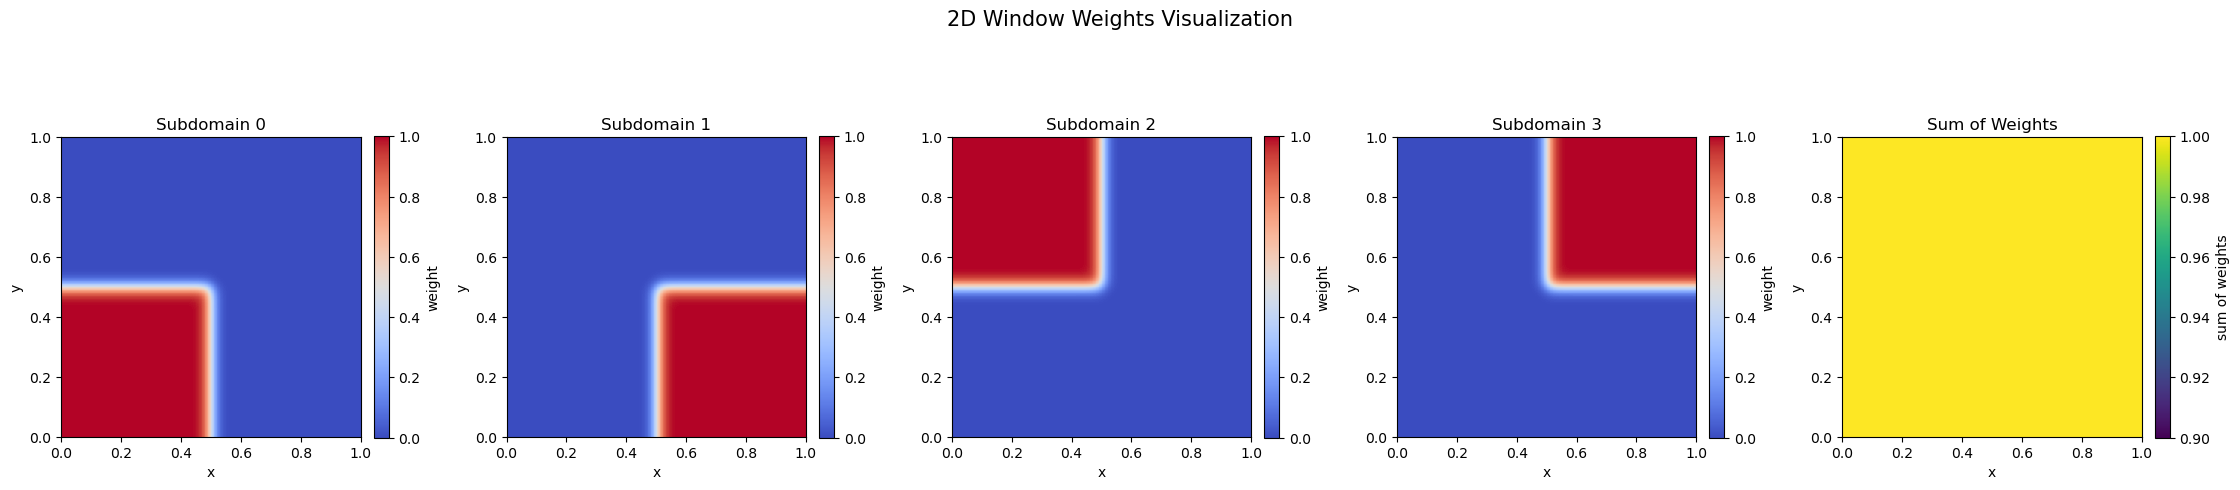

NameError: name '_init_fcn_layer' is not defined

In [2]:
from __future__ import annotations
import jax
import jax.numpy as jnp
import optax
import equinox as eqx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
from typing import Callable, Sequence

class MyCustomFCN(eqx.Module):
    layers: tuple
    activation: eqx.static_field()

    def __init__(self, key, in_size, out_size, width_size, depth, activation):
        subkeys = jax.random.split(key, depth + 1)
        layer_list = []
        current_in = in_size
        for i in range(depth):
            W, b = _init_fcn_layer(subkeys[i], current_in, width_size)
            layer_list.append((W, b))
            current_in = width_size
        W, b = _init_fcn_layer(subkeys[-1], current_in, out_size)
        layer_list.append((W, b))
        self.layers = tuple(layer_list)
        self.activation = activation

    def __call__(self, x: jax.Array) -> jax.Array:
        if x.ndim == 1: x = jnp.expand_dims(x, axis=0)
        for (W, b) in self.layers[:-1]:
            x = self.activation(x @ W.T + b)
        W_final, b_final = self.layers[-1]
        x = x @ W_final.T + b_final
        return x

##############################################################################
# 1) PDE 定义：Poisson2D_freq
##############################################################################
class PDEProblem:
    domain = (None, None)
    def residual(self, model, x):
        raise NotImplementedError
    def exact(self, x):
        raise NotImplementedError
    def ansatz(self, x, nn_out):
        raise NotImplementedError

class Poisson2D_freq(PDEProblem):
    """
    2-D Poisson problem on Ω = [0,1]²
        -Δu = f(x, y),     u|_{∂Ω} = 0
    Exact solution (for testing):
        u(x,y) = sin(6π x²) * sin(8π y²)
    """

    domain = (jnp.array([0.0, 0.0]), jnp.array([1.0, 1.0]))  # 2D

    @staticmethod
    def exact(xy):
        """ The new exact solution. """
        x, y = xy[..., 0], xy[..., 1]
        return jnp.sin(6 * jnp.pi * x**2) * jnp.sin(8 * jnp.pi * y**2)

    @staticmethod
    def ansatz(xy, nn_out):
        """ Enforces zero boundary conditions: u(x,y) = x(1-x)y(1-y) * NN(x,y). """
        x = xy[..., 0]
        y = xy[..., 1]
        factor = x * (1 - x) * y * (1 - y)  # (N,)
        factor = factor[..., None]          # (N,1)
        return factor * nn_out              # (N,1)

    @staticmethod
    def rhs(xy):
        """ The new right-hand side (source term) f = -Δu. """
        x, y = xy[..., 0], xy[..., 1]
        sin_6pix2 = jnp.sin(6 * jnp.pi * x**2)
        sin_8piy2 = jnp.sin(8 * jnp.pi * y**2)
        cos_6pix2 = jnp.cos(6 * jnp.pi * x**2)
        cos_8piy2 = jnp.cos(8 * jnp.pi * y**2)

        # d^2u/dx^2 term multiplied by sin(8πy^2)
        du_dxx_term = (12 * jnp.pi * cos_6pix2 - 144 * jnp.pi**2 * x**2 * sin_6pix2) * sin_8piy2
        
        # d^2u/dy^2 term multiplied by sin(6πx^2)
        du_dyy_term = (16 * jnp.pi * cos_8piy2 - 256 * jnp.pi**2 * y**2 * sin_8piy2) * sin_6pix2
        
        # f = - (d^2u/dx^2 + d^2u/dy^2)
        return -(du_dxx_term + du_dyy_term)

    def _single_res(self, model, xy_batch):
        """Residual = mean(( -laplacian(u) - f )^2) over xy_batch."""
        if xy_batch.shape[0] == 0:
            return 0.0

        def u_fn(pt_2d):
            out = model(pt_2d)  # shape=(1,1) or scalar
            return out.squeeze()

        hessian_fn = jax.jacfwd(jax.jacrev(u_fn))
        hessians   = jax.vmap(hessian_fn)(xy_batch)
        laplacians = jnp.trace(hessians, axis1=-2, axis2=-1)
        f_vals = self.rhs(xy_batch)
        return jnp.mean( ( -laplacians - f_vals )**2 )

    def residual(self, model, xy):
        """
        Calculates the residual for a single batch.
        Assumes xy is a single batch of shape (N, 2).
        """
        return self._single_res(model, xy)


##############################################################################
# 2) 窗口函数：my_precise_window_func
##############################################################################
Pi = jnp.pi
def my_precise_window_func(xmins_all, xmaxs_all,
                           wmins_all, wmaxs_all,     # 占位
                           x, tol: float = 1e-12):
    """
    Cos² window (C² 连续, FBPINN-style)
    输入:
        xmins_all, xmaxs_all : (n_sub, d)
        x                    : (N,d) 或 (d,)
    返回:
        w : (N, n_sub)   已归一化,  ∑_sub w = 1
    """

    # ---------- 保证形状齐全 ----------
    xmins_all = jnp.asarray(xmins_all)
    xmaxs_all = jnp.asarray(xmaxs_all)
    x         = jnp.asarray(x)

    if xmins_all.ndim == 1:                 # (n_sub,) ➔ (n_sub,1)
        xmins_all = xmins_all[:, None]
        xmaxs_all = xmaxs_all[:, None]
    if x.ndim == 1:                         # (d,)     ➔ (1,d)  ← 修正
        x = x[None, :]

    # ---------- 广播到 (N, n_sub, d) ----------
    x_   = x[:, None, :]                    # (N,1,d)
    xmin = xmins_all[None, :, :]            # (1,n_sub,d)
    xmax = xmaxs_all[None, :, :]

    mu = (xmin + xmax) / 2.0
    sd = (xmax - xmin) / 2.0 + tol

    r     = (x_ - mu) / sd                 # 归一化到 [-1,1]
    core  = 0.25 * (1.0 + jnp.cos(Pi * r))**2
    w_dim = jnp.where(jnp.abs(r) <= 1.0, core, 0.0)

    # ---------- 子域原始权重 ----------
    w_raw = jnp.prod(w_dim, axis=-1)        # (N, n_sub)

    # ---------- POU 归一化 ----------
    denom = jnp.maximum(w_raw.sum(axis=1, keepdims=True), 1e-12)
    w = w_raw / denom                       # (N, n_sub)

    return w
    

##############################################################################
# 3) 子域生成 & 全域 collocation
##############################################################################
def generate_subdomains(domain, n_sub_per_dim, overlap):
    """
    Generate uniformly spaced subdomains (with overlap) in 1D or multi-D.

    Args:
        domain: tuple of (lower_bounds: jnp.array, upper_bounds: jnp.array), shape (d,)
        n_sub_per_dim: int or list of ints for each dim
        overlap: float (relative size, e.g., 0.2)

    Returns:
        subdomains: list of (left: jnp.array, right: jnp.array)
    """
    if isinstance(n_sub_per_dim, int):
        n_sub_per_dim = [n_sub_per_dim] * len(domain[0])  # scalar → list

    dim = len(domain[0])
    grid_axes = []
    step_sizes = []
    for i in range(dim):
        a, b = domain[0][i], domain[1][i]
        n = n_sub_per_dim[i]
        total_len = b - a
        step = total_len / (n-1)
        #centers = jnp.linspace(a + step / 2, b - step / 2, n)
        centers = jnp.linspace(a, b, n)
        print("centers",centers)
        grid_axes.append(centers)
        step_sizes.append(step)

    mesh = jnp.meshgrid(*grid_axes, indexing='ij')  # multi-D center coords
    center_points = jnp.stack([m.reshape(-1) for m in mesh], axis=-1)  # (n_sub_total, d)

    subdomains = []
    for center in center_points:
        width = jnp.array(step_sizes)/2 + overlap/2 # half
        left = center - width
        right = center + width
        #left = center - width / 2
        #right = center + width / 2
        subdomains.append((left, right))

    return subdomains


def generate_whole_domain_collocation(domain, n_pts):
    """
    在整个 domain=[(0,0),(1,1)] 上均匀采样 n_pts^2，
    而不区分子域 => window function 会在各子域外衰减.
    """
    (x_lo,y_lo),(x_hi,y_hi)= domain
    xs= jnp.linspace(x_lo, x_hi, n_pts)
    ys= jnp.linspace(y_lo, y_hi, n_pts)
    XX,YY= jnp.meshgrid(xs,ys, indexing='ij')
    colloc_pts= jnp.column_stack([XX.ravel(), YY.ravel()])
    return colloc_pts  # shape=(n_pts^2, 2)

##############################################################################
# 4) FBPINN
##############################################################################
# Dense layer
class Dense(eqx.Module):
    weight: jax.Array
    bias: jax.Array
    activation: Callable | None = eqx.static_field()

    def __init__(
        self,
        key: jax.Array,
        in_features: int,
        out_features: int,
        activation: Callable | None = jax.nn.tanh,
    ):
        w_key, b_key = jax.random.split(key)
        limit = jnp.sqrt(1.0 / in_features)
        self.weight = jax.random.uniform(
            w_key, (out_features, in_features), minval=-limit, maxval=limit
        )
        self.bias = jax.random.uniform(
            b_key, (out_features,), minval=-limit, maxval=limit
        )
        self.activation = activation

    def __call__(self, x: jax.Array) -> jax.Array:
        y = x @ self.weight.T + self.bias
        return self.activation(y) if self.activation is not None else y


class FCN(eqx.Module):
    """MLP"""
    layers: tuple[Dense, ...]

    def __init__(
        self,
        key: jax.Array,
        in_size: int,
        out_size: int,
        hidden_sizes: Sequence[int] | int = 64,
        activation: Callable = jax.nn.tanh,
        final_activation: Callable | None = None,
    ):
        if isinstance(hidden_sizes, int):
            hidden_sizes = [hidden_sizes]
        keys = jax.random.split(key, len(hidden_sizes) + 1)
        sizes = [in_size, *hidden_sizes, out_size]

        self.layers = tuple(
            Dense(
                k,
                in_features=sizes[i],
                out_features=sizes[i + 1],
                activation=activation if i < len(hidden_sizes) else final_activation,
            )
            for i, k in enumerate(keys)
        )

    def __call__(self, x: jax.Array) -> jax.Array:
        x = jnp.atleast_2d(x)
        for dense in self.layers:
            x = dense(x)
        return x

class FBPINN(eqx.Module):
    subnets: tuple
    ansatz: callable= eqx.static_field()
    xmins_all: jax.Array= eqx.static_field()
    xmaxs_all: jax.Array= eqx.static_field()
    wmins_all_fixed: jax.Array= eqx.static_field()
    wmaxs_all_fixed: jax.Array= eqx.static_field()
    num_subdomains: int= eqx.static_field()
    xdim: int= eqx.static_field()
    model_out_size: int= eqx.static_field()

    def __init__(self, key, subdomains, ansatz, mlp_config, fixed_transition):
        self.ansatz= ansatz
        self.xdim= mlp_config["in_size"]
        self.model_out_size= mlp_config["out_size"]

        if not subdomains:
            self.num_subdomains=0
            self.subnets= tuple()
            pshape= (0,self.xdim)
            self.xmins_all= jnp.empty(pshape)
            self.xmaxs_all= jnp.empty(pshape)
            self.wmins_all_fixed= jnp.empty(pshape)
            self.wmaxs_all_fixed= jnp.empty(pshape)
        else:
            self.num_subdomains= len(subdomains)
            s_mins= [s[0] for s in subdomains]
            s_maxs= [s[1] for s in subdomains]
            self.xmins_all= jnp.stack(s_mins)
            self.xmaxs_all= jnp.stack(s_maxs)
            self.wmins_all_fixed= jnp.full((self.num_subdomains,self.xdim), fixed_transition)
            self.wmaxs_all_fixed= jnp.full((self.num_subdomains,self.xdim), fixed_transition)

            keys= jax.random.split(key, self.num_subdomains)
            self.subnets= tuple(
                MyCustomFCN(k,
                            in_size= self.xdim,
                            out_size=self.model_out_size,
                            width_size= mlp_config["width_size"],
                            depth= mlp_config["depth"],
                            activation= mlp_config["activation"])
                for k in keys
            )

    def _normalize_x(self, i_sub, x):
        left= self.xmins_all[i_sub]
        right= self.xmaxs_all[i_sub]
        center= (left+right)/2.
        scale= (right-left)/2.
        return (x-center)/ jnp.maximum(scale, 1e-9)

    def total_solution(self, x):
        """
        x shape=(N,2).
        We do subdomain-wise MLP + weight, then sum.
        """
        if self.num_subdomains==0:
            return jnp.zeros_like(x[...,0:1])

        w_raw= my_precise_window_func(self.xmins_all, self.xmaxs_all,
                                      self.wmins_all_fixed, self.wmaxs_all_fixed,
                                      x, tol=1e-8)
        out_list=[]
        for i_sub in range(self.num_subdomains):
            xnorm= self._normalize_x(i_sub, x)
            raw_i= self.subnets[i_sub](xnorm)
            w_i= w_raw[:, i_sub]
            out_i= raw_i*w_i[:,None] if raw_i.ndim==2 else raw_i*w_i
            out_list.append(out_i)
        sum_out= jnp.sum(jnp.stack(out_list,axis=0), axis=0)
        return self.ansatz(x, sum_out)

    def __call__(self, x):
        return self.total_solution(x)

##############################################################################
# 5) 在开始时可视化子域窗口函数
##############################################################################
def plot_window_weights_2d(domain_bounds, subdomains,
                           transition, n_points=50, tol_plot=1e-3):
    """
    2D 窗口函数可视化：对于每个子域，各画一个子图，并加一张“Sum of Weights”图。
    - 不显示子域边框
    - 不显示底部彩条
    """
    # 解包域范围
    (x_lo, y_lo), (x_hi, y_hi) = domain_bounds

    # 生成网格
    x_vals = jnp.linspace(x_lo, x_hi, n_points)
    y_vals = jnp.linspace(y_lo, y_hi, n_points)
    X, Y = jnp.meshgrid(x_vals, y_vals, indexing="ij")
    XY_flat = jnp.column_stack([X.ravel(), Y.ravel()])

    # 准备子域
    xmins = jnp.stack([s[0] for s in subdomains])  # (n_sub, 2)
    xmaxs = jnp.stack([s[1] for s in subdomains])
    wmins = jnp.full_like(xmins, transition)
    wmaxs = jnp.full_like(xmaxs, transition)

    # 计算权重
    w_raw = my_precise_window_func(xmins, xmaxs, wmins, wmaxs, XY_flat, tol=tol_plot)
    n_sub = len(subdomains)

    # 各子域 weight map
    w_maps = [w_raw[:, i].reshape(n_points, n_points) for i in range(n_sub)]
    w_sum = jnp.sum(w_raw, axis=1).reshape(n_points, n_points)

    # 创建 (n_sub + 1) 个并排子图
    fig, axs = plt.subplots(1, n_sub + 1,
                            figsize=(4.5*(n_sub + 1), 5),
                            subplot_kw=dict(aspect="equal"))
    if n_sub == 1:
        axs = [axs]

    fig.suptitle("2D Window Weights Visualization", fontsize=15, y=1.02)

    # 1) 各子域图
    norm_sub = mcolors.Normalize(vmin=0.0, vmax=1.0)
    for i, ax in enumerate(axs[:-1]):
        im = ax.imshow(
            w_maps[i],
            extent=[x_lo, x_hi, y_lo, y_hi],
            origin="lower",
            cmap="coolwarm",
            norm=norm_sub
        )
        ax.set_title(f"Subdomain {i}")
        ax.set_xlabel("x")
        ax.set_ylabel("y")

        # 加 colorbar
        cb = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cb.set_label("weight", rotation=90)

    # 2) 最后一张图：Sum of Weights
    ax_sum = axs[-1]
    vmax_sum = float(w_sum.max())  
    norm_sum = mcolors.Normalize(vmin=0.9, vmax=vmax_sum)
    im_sum = ax_sum.imshow(
        w_sum,
        extent=[x_lo, x_hi, y_lo, y_hi],
        origin="lower",
        cmap="viridis",
        norm=norm_sum
    )
    ax_sum.set_title("Sum of Weights")
    ax_sum.set_xlabel("x")
    ax_sum.set_ylabel("y")

    cb_sum = fig.colorbar(im_sum, ax=ax_sum, fraction=0.046, pad=0.04)
    cb_sum.set_label("sum of weights", rotation=90)

    plt.tight_layout()
    plt.show()

##############################################################################
# 6) 主程序
##############################################################################
if __name__=="__main__":
    # PDE
    pde= Poisson2D_freq()

    # 1) 生成子域 (只是为了定义 subnets, window function)
    #n_sub_x, n_sub_y= 2, 2
    n_sub_per_dim = 2
    overlap= 0.2
    tol = 1e-8
    subdomains= generate_subdomains(pde.domain, n_sub_per_dim, overlap)
    print(subdomains)
    domain_2d = (jnp.array([0., 0.]), jnp.array([1., 1.]))

    # 2) 先可视化子域窗函数
    plot_window_weights_2d(
        domain_bounds=domain_2d,
        subdomains=subdomains,
        transition=overlap,
        n_points=100,
        tol_plot=tol
    )

    # 3) 构造 FBPINN
    mlp_config= {
        "in_size": 2,
        "out_size": 1,
        "width_size": 64,
        "depth": 2,
        "activation": jax.nn.tanh
    }
    key= jax.random.PRNGKey(1)
    fb_model= FBPINN(key, subdomains, pde.ansatz, mlp_config, fixed_transition=overlap)
    print(f"Number of subdomains: {fb_model.num_subdomains}")

    # 4) 在 [0,1]^2 全域采点 => n_pts x n_pts
    #    这里 window function 会自动让子域外贡献衰减
    n_pts_global= 50
    colloc_pts= generate_whole_domain_collocation(pde.domain, n_pts_global)
    print("Collocation points shape=", colloc_pts.shape)

    # 5) 优化器
    lr= 1e-3
    steps= 1000
    optimizer= optax.adam(lr)
    import optax
    #weight_decay = 1e-4        # L2 衰减系数

    '''optimizer = optax.adamw(
        learning_rate = lr,
        weight_decay  = weight_decay,   # decoupled weight decay
        b1 = 0.9, b2 = 0.999, eps = 1e-8   # 其余超参与 Adam 相同，可不填
    )'''
    opt_state= optimizer.init(eqx.filter(fb_model, eqx.is_array))

    @eqx.filter_jit
    def train_step(model, opt_s, x_batch):
        loss_val, grads= eqx.filter_value_and_grad(lambda m: pde.residual(m, x_batch))(model)
        updates, opt_s_new= optimizer.update(grads, opt_s, model)
        model_new= eqx.apply_updates(model, updates)
        return model_new, opt_s_new, loss_val

    # 6) 训练循环
    pde_loss_history= []
    l1_error_history= []
    log_interval= 100

    # 测试网格
    test_n= 80
    xs_t= jnp.linspace(0,1, test_n)
    ys_t= jnp.linspace(0,1, test_n)
    XX,YY= jnp.meshgrid(xs_t, ys_t, indexing="ij")
    xy_test= jnp.column_stack([XX.ravel(), YY.ravel()])
    exact_vals= pde.exact(xy_test).reshape(test_n, test_n)

    print("Start training...")
    for step_i in range(steps):
        fb_model, opt_state, loss_val= train_step(fb_model, opt_state, colloc_pts)
        if step_i%log_interval==0 or step_i==steps-1:
            # PDE loss
            pde_loss_history.append(loss_val.item())
            # L1 error
            pred_test= fb_model(xy_test).reshape(test_n, test_n)
            l1_err= jnp.mean(jnp.abs(pred_test - exact_vals))
            l1_error_history.append(l1_err.item())
            print(f"Step={step_i}, PDE_loss={loss_val:.3e}, L1={l1_err:.3e}")

    final_pred= fb_model(xy_test).reshape(test_n, test_n)
    final_l1= jnp.mean(jnp.abs(final_pred - exact_vals))
    print(f"\nFinal L1 error= {final_l1:.3e}")

    # 7) 可视化数值解 vs 真解
    fig, axs= plt.subplots(1,2, figsize=(10,4), subplot_kw={"aspect":"equal"})
    im0= axs[0].imshow(final_pred, extent=[0,1,0,1], origin="lower", cmap="viridis")
    plt.colorbar(im0, ax=axs[0])
    axs[0].set_title("FBPINN Pred")
    im1= axs[1].imshow(exact_vals, extent=[0,1,0,1], origin="lower", cmap="viridis")
    plt.colorbar(im1, ax=axs[1])
    axs[1].set_title("Exact: sin(2πx²)*sin(2πy²)")
    plt.suptitle("FBPINN 2D Poisson: -Δu=f, u|∂Ω=0", fontsize=14)
    plt.show()

    # 8) Loss & L1 曲线
    plt.figure()
    step_axis= [i*log_interval for i in range(len(pde_loss_history)-1)] + [steps]
    plt.plot(step_axis, pde_loss_history, "-", label="PDE Loss")
    plt.plot(step_axis, l1_error_history, "-", label="L1 Error")
    plt.yscale("log")
    plt.grid(True, ls=":")
    plt.xlabel("Training Step")
    plt.ylabel("Value (log scale)")
    plt.title("Training PDE Loss & L1")
    plt.legend()
    plt.show()
    
    # 7) 可视化数值解 vs 真解 vs 误差
    err_abs = jnp.abs(final_pred - exact_vals)          # <-- 新增：绝对误差 (50×50)
    v = err_abs.max()
    fig, axs = plt.subplots(1, 3, figsize=(15, 4), subplot_kw={"aspect": "equal"})

    # (a) 预测
    im0 = axs[0].imshow(final_pred,
                        extent=[0, 1, 0, 1], origin="lower", cmap="viridis",vmin=-1.0, vmax=1.0)
    plt.colorbar(im0, ax=axs[0])
    axs[0].set_title("FBPINN Pred")

    # (b) 精确解
    im1 = axs[1].imshow(exact_vals,
                        extent=[0, 1, 0, 1], origin="lower", cmap="viridis",vmin=-1.0, vmax=1.0)
    plt.colorbar(im1, ax=axs[1])
    axs[1].set_title("Exact: sin(2πx²)·sin(2πy²)")

    # (c) 绝对误差 |û – u|
    im2 = axs[2].imshow(err_abs,
                        extent=[0, 1, 0, 1], origin="lower",
                        cmap="viridis",vmin = -v, vmax = v)
    plt.colorbar(im2, ax=axs[2])
    axs[2].set_title("Absolute Error")

    plt.suptitle("FBPINN 2D Poisson −Δu=f , u|∂Ω=0", fontsize=14)
    plt.tight_layout()
    plt.show()
